In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics

In [132]:
from nltk.corpus import stopwords

Ucitani su podaci preko excell tabele koja je skinuta sa "https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets" web stranice.

In [133]:
data = pd.read_csv('sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['Sentiment', 'Tweet ID', 'Date', 'Query', 'Username', 'Tweet'])

In [134]:
data.head(2)

,Sentiment,Tweet ID,Date,Query,Username,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


Sentiment atribut oznacava da li je tvit pozitivan ili negativan. Vrednosti oznacene sa 0 odgovaraju negativnom sentimentu, 2 odgovara neutralnom sentimentu, dok 4 odgovara pozitivnom sentimentu

In [135]:
sentiments = data['Sentiment'].value_counts().keys()
sentiments

Index([0, 4], dtype='int64', name='Sentiment')

In [136]:
np.unique(sentiments)

array([0, 4], dtype=int64)

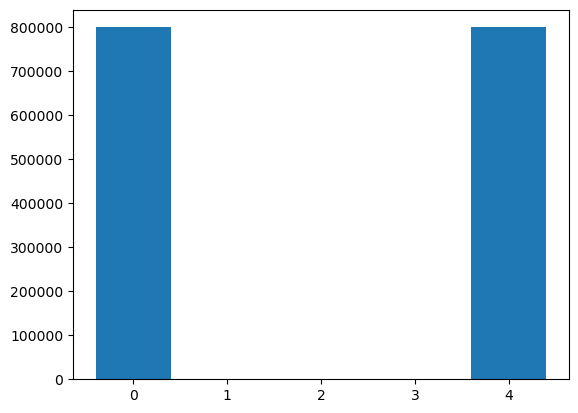

In [137]:
plt.bar(data['Sentiment'].value_counts().keys(), data['Sentiment'].value_counts().values)
plt.show()

Kao sto mozemo da primetimo, uklonjeni su svi neutralni sentimenti, sa tim na umu su remapirane ciljne vrednosti u 0 (negativan) i 1 (pozitivan)

In [138]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [139]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

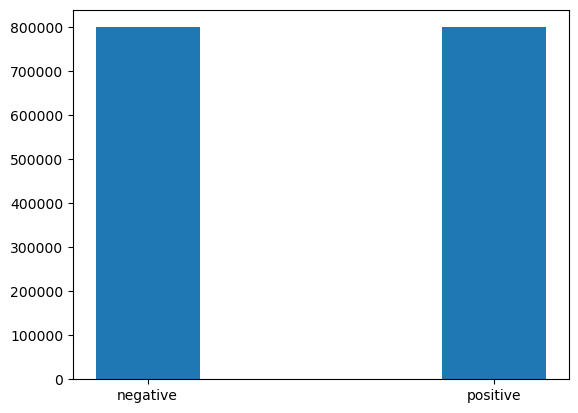

In [140]:
plt.bar(data['Sentiment'].value_counts().keys(),data['Sentiment'].value_counts().values, width = 0.3)
plt.xticks([0,1], labels=['negative', 'positive'])
plt.show()

In [141]:
data['Tweet']

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: Tweet, Length: 1600000, dtype: object

Kao sto se moze primetiti vecina tweetova su usmereni ka nekom specificnom korisniku, sto u vecini slucajeva nema uticaj na sam sentiment, shodno tome su korisnicka imena uklonjena sledecom funkcijom.

In [142]:
def username_removal(string):
    
    for i in range(string.count('@')): 
        username_begin_index = string.find('@')
        username_end_index = string[username_begin_index::].find(' ') + username_begin_index
    
        string = string.replace(string[username_begin_index:username_end_index+1],' ')
    
    return string                    

In [143]:
x = data['Tweet']
y = data['Sentiment']

In [144]:
num_of_chars = 0
for i in range(x.shape[0]):
    if not bool(x[i].find('@')):
        num_of_chars+=1
        #print('@ is at: ', i)
print("number of @ found is: ", num_of_chars)

number of @ found is:  698079


Kao sto mozemo da vidimo preko 40% tweetova sadrzi referencu ka nekom korisnickom nalogu

In [145]:
x = x.apply(username_removal)

In [146]:
num_of_chars = 0
for i in range(x.shape[0]):
    if not bool(x[i].find('@')):
        num_of_chars+=1
        #print('@ is at: ', i)
print("number of @ found is: ", num_of_chars)

number of @ found is:  0


Kao sto mozemo da primetimo svi "@" su uklonjeni iz tweetova

In [147]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (1600000,)
y shape:  (1600000,)


Napravljen su skupovi za validaciju gde su testirani su hiperparametri za min_df i max_df kako bi se pronasli najbolji isti, uradjeno je u vise iteracije i najbolji skupovi za treniranje su sledeci

In [148]:
x_train_validation, x_test, y_train_validation, y_test = model_selection.train_test_split(x,y,train_size=0.1,test_size=0.05, stratify=y, random_state=7)

In [149]:
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(x_train_validation, y_train_validation, train_size=0.8, stratify=y_train_validation, random_state=7)

In [150]:
min_freq = [28,29,30,31,32]
max_freq = [3600,4000,5000,6000,7000]

In [151]:
best_min_freq = None
best_max_freq = None
best_score = float('-inf')

for minfreq in min_freq:
    for maxfreq in max_freq:
        model = linear_model.LinearRegression()

        tweet_count_vectorizer = feature_extraction.text.CountVectorizer(min_df = minfreq, max_df = maxfreq, stop_words=stopwords.words('english'))
        tweet_count_vectorizer.fit(x_train)

        x_train_vectorized = tweet_count_vectorizer.transform(x_train)
        x_validation_vectorized = tweet_count_vectorizer.transform(x_validation)
        
        model.fit(x_train_vectorized,y_train)
        score = model.score(x_validation_vectorized, y_validation)
        
        if score > best_score:
            best_score = score
            best_min_freq = minfreq
            best_max_freq = maxfreq
            
print('best_score = {}, best_min_freq = {}, best_max_freq = {}'.format(best_score, best_min_freq, best_max_freq))
        
        

best_score = 0.283925317495773, best_min_freq = 32, best_max_freq = 7000


Napravljena je vektorska reprezentacija teksta metodom Vreca reci sa najboljim hiperparametrima.

In [152]:
tweet_count_vectorizer = feature_extraction.text.CountVectorizer(min_df=best_min_freq, max_df=best_max_freq, stop_words=stopwords.words('english'))

In [153]:
tweet_count_vectorizer.fit(x_train)

CountVectorizer(max_df=7000, min_df=32,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [154]:
feature_names = tweet_count_vectorizer.get_feature_names_out()

In [155]:
len(feature_names)

3085

In [156]:
x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_test_vectorized = tweet_count_vectorizer.transform(x_test)

# Model 1 - logisticka regresija

In [157]:
model1 = linear_model.LogisticRegression()

In [158]:
model1.fit(x_train_vectorized,y_train)

D:\Users\mata2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Tacnost modela na trening i test skupu

In [159]:
model1_skor_train = model1.score(x_train_vectorized, y_train)
model1_skor_test = model1.score(x_test_vectorized, y_test)

In [160]:
print("skor na podacima za treniranje: ", model1_skor_train)
print('skor na podacima za testiranje: ', model1_skor_test)

skor na podacima za treniranje:  0.7705078125
skor na podacima za testiranje:  0.7553


### Matrica konfuzije - logisticka regresija

In [161]:
y_predicted_lr = model1.predict(x_test_vectorized)

In [162]:
matrica_konfuzije_lr = metrics.confusion_matrix(y_test, y_predicted_lr)
matrica_konfuzije_lr

array([[28647, 11353],
       [ 8223, 31777]], dtype=int64)

In [163]:
metrics.f1_score(y_test, y_predicted_lr)

0.7645134127270541

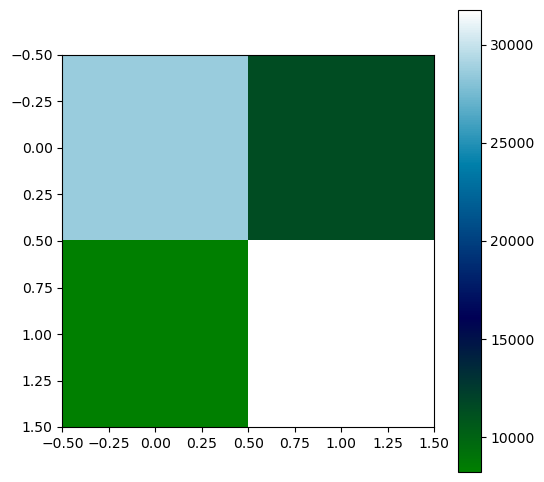

In [164]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_lr, cmap='ocean')
plt.colorbar()
plt.show()

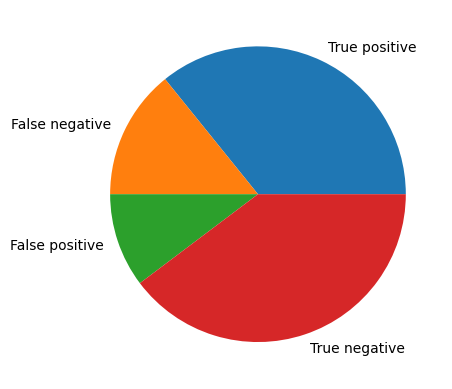

In [165]:
plt.pie(matrica_konfuzije_lr.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 2 - linearni SVM

In [166]:
model2 = svm.LinearSVC()

In [167]:
model2.fit(x_train_vectorized, y_train)

D:\Users\mata2\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [168]:
model2_skor_train = model2.score(x_train_vectorized, y_train)
model2_skor_test = model2.score(x_test_vectorized, y_test)

In [169]:
print("skor na podacima za treniranje: ", model2_skor_train)
print('skor na podacima za testiranje: ', model2_skor_test)

skor na podacima za treniranje:  0.76959375
skor na podacima za testiranje:  0.7539


In [170]:
y_pred_svm = model2.predict(x_test_vectorized)
matrica_konfuzije_svm = metrics.confusion_matrix(y_test, y_pred_svm)
matrica_konfuzije_svm

array([[28289, 11711],
       [ 7977, 32023]], dtype=int64)

### Matrica konfuzije - linearni SVM

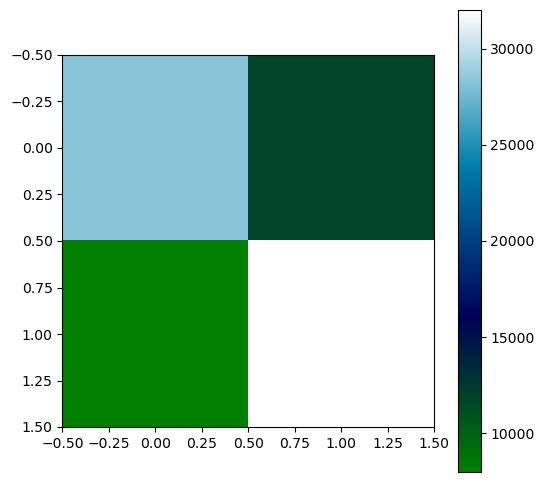

In [171]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_svm, cmap='ocean')
plt.colorbar()
plt.show()

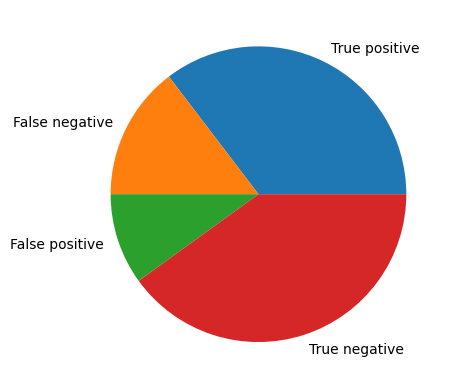

In [172]:
plt.pie(matrica_konfuzije_svm.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 3 - k najblizih suseda

Testirani su hiperparametri za najbolji broj suseda. K najblizih suseda je radjen sa manjim % podataka zbog vremenskih poteskoca pri treniranju modela

In [173]:
num_neighbors = [6,8,10,12,15]

In [174]:
x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_validation_vectorized = tweet_count_vectorizer.transform(x_validation)

In [175]:
best_score = float('-inf')
best_neigh = None

for neigh in num_neighbors:
    model = neighbors.KNeighborsClassifier(n_neighbors=neigh)
    model.fit(x_train_vectorized, y_train)
    score = model.score(x_validation_vectorized, y_validation)
        
    if score > best_score:
        best_score = score
        best_neigh = neigh
print('best score = {}, best neighbor num = {}'.format(best_score, best_neigh))

best score = 0.67453125, best neighbor num = 12


Napravljen je model sa najboljim hiperparametrima

In [176]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=best_neigh)

In [177]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=12)

In [178]:
model3_skor_train = model3.score(x_train_vectorized, y_train)
model3_skor_test = model3.score(x_test_vectorized, y_test)

In [179]:
print("skor na podacima za treniranje: ", model3_skor_train)
print('skor na podacima za testiranje: ', model3_skor_test)

skor na podacima za treniranje:  0.7291171875
skor na podacima za testiranje:  0.67285


In [180]:
y_pred_kneigh = model3.predict(x_test_vectorized)
matrica_konfuzije_kneigh = metrics.confusion_matrix(y_test, y_pred_kneigh)
matrica_konfuzije_kneigh

array([[25436, 14564],
       [11608, 28392]], dtype=int64)

### Matrica konfuzije - k najblizih suseda

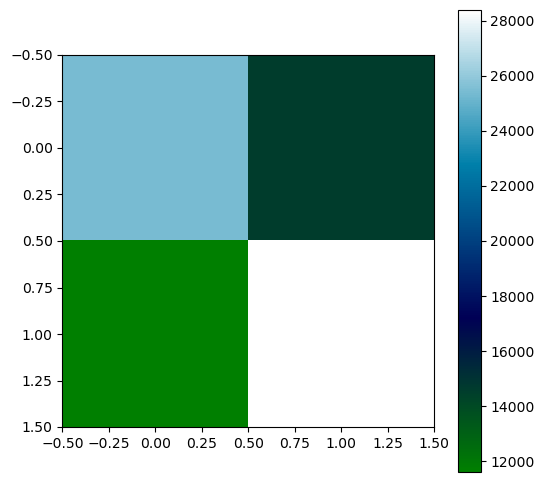

In [181]:
plt.figure(figsize=(6, 6))
plt.imshow(matrica_konfuzije_kneigh, cmap='ocean')
plt.colorbar()
plt.show()

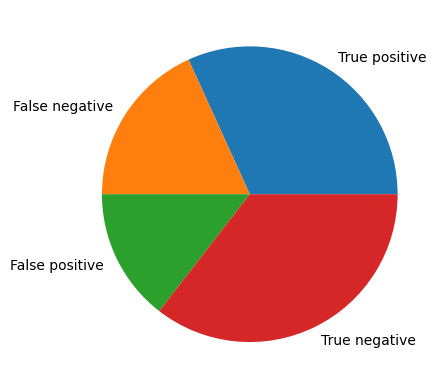

In [182]:
plt.pie(matrica_konfuzije_kneigh.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

In [183]:
rezultati = [[model1_skor_train, model1_skor_test],[model2_skor_train,model2_skor_test],[model3_skor_train,model3_skor_test]]
pd.DataFrame(rezultati, columns=["score na treniranju", "score na testu"], index = ['Log Reg','SVM','K-neigh'])

,score na treniranju,score na testu
Log Reg,0.770508,0.75530
SVM,0.769594,0.75390
K-neigh,0.729117,0.67285
